**Date** 24/11/2025
**Author** Jordi Torres
Core code based on work by professor Gaillard. 

**EXERCISE 2** Ayagari + employment status + search effort and ex destruction rate

In [1]:
#libraries 

using Printf;
using Roots;
using Plots;
using Distributions;
using LambertW;

#wider page display
display("text/html", "<style>.container { width:100% !important; }</style>")

In [2]:
const size_k 	= 1000;    #number of grid points     
const size_m 	= 7;       #number of productivity classes

const size_e =2 ; #added!

const kmin 		= 0.0;
const kmax 		= 1700.0;

betapar 	= 0.96;
const alphapar 	= 0.36;
const deltapar 	= 0.08;
const rhopar 	= 3.0;
const labor 	= 1.0219882;

const epsV    = 1.0e-6
const epsdist = 1.0e-8
const epsK    = 1.0e-6   # for debugging


## grid constants
const scale1 = 1.6;
const grmin = (kmin/scale1)-1.0;
const exponen=log((kmax/scale1)-grmin)/(size_k-1);

const sstates = [exp(-0.600000000000000)	  exp(-0.400000000000000)	  exp(-0.200000000000000)	  exp(0.000000000000000)	   exp(0.200000000000000)	   exp(0.400000000000000)	   exp(0.600000000000000)];

const strans = [	
    0.046746218637144	   0.217937777267117	   0.397822606398702	   0.266386738072197	   0.065169922261456	   0.005754191945237	   0.000182545418147;	
	0.023199661746751	   0.149524091076020	   0.369020347246402	   0.333823905199677	   0.110578117872631	   0.013276146769082	   0.000577730089437;	
	0.010548958644399	   0.093657511915497	   0.312761268311836	   0.382193227897354	   0.171253064028981	   0.027919224002876	   0.001666745199056;	
	0.004387354018187	   0.053538402796357	   0.242163972572887	   0.399820541225137	   0.242163972572887	   0.053538402796357	   0.004387354018187;	
	0.001666745199056	   0.027919224002876	   0.171253064028981	   0.382193227897354	   0.312761268311837	   0.093657511915497	   0.010548958644399;	
	0.000577730089436	   0.013276146769082	   0.110578117872631	   0.333823905199677	   0.369020347246403	   0.149524091076020	   0.023199661746751;	
	0.000182545418147	   0.005754191945237	   0.065169922261456	   0.266386738072197	   0.397822606398702	   0.217937777267117	   0.046746218637144];

#extension:

 b= 0.35
 tau_wage=0.25
    β = 0.96     # baseline  
    κ = 0.4     # used in most papers
const ν= 0.04

etrans = [
	0.04 0.96
]

emplo = [0.0, 1.0]

2-element Vector{Float64}:
 0.0
 1.0

In [3]:
function utility(cons::Float64)
    cons_adj = max(cons, 1.0e-8)      
    return (cons_adj^(1.0-rhopar)) / (1.0 - rhopar)
end


function invmargutil(x::Float64)
    x_adj = max(x, 1.0e-12)     # ensure strictly positive
    return x_adj^(-1.0/rhopar)
end

##add!!!!!

invmargutil (generic function with 1 method)

In [4]:
function inter1d(x1::Float64,y1::Float64,y2::Float64) 
    return ((1.0-(x1))*(y1)+(x1)*(y2))
end

function getwage(rrate::Float64)
    return (1.0-alphapar)*(alphapar/(rrate+deltapar))^(alphapar/(1.0-alphapar));
end

function getlevel(igrid::Int64)
    #careful this function assumes that grid starts at 0
    return ( scale1*(exp(exponen*(igrid))+grmin) );
end

function getgrid(x::Float64)
    #careful because indexes start at 1 in Julia, a +1.0 was added
    return (log((x)/scale1-grmin)/exponen)+1.0;
end


function get_x(EV::Float64, κ::Float64, β::Float64)
    x_star=0.0
    if EV>=0 ##assumption on ties???
     x_star= (1/κ)*lambertw(κ^2.0 *β*EV)
    end
    return x_star
end

function get_xi(x_star::Float64, κ::Float64)
    return  1- exp(-κ*x_star)
end

get_xi (generic function with 1 method)

In [5]:
function nderiv(val1::Float64,val2::Float64,val3::Float64,x1::Float64,x2::Float64,x3::Float64) 
    return ((1.0 - (x3 - x2)/(x3 - x1))*((val3 - val2)/(x3-x2)) + ((x3 - x2)/(x3 - x1))*((val2 - val1)/(x2-x1)));
end

nderiv (generic function with 1 method)

In [6]:
function POLICY_we(
    valueF::Array{Float64,3},
    dvalueF::Array{Float64,3},
    save::Array{Float64,3},
    wagerate::Float64,
    rrate::Float64,
    grid::Array{Float64},
    betapar::Float64,
    tau_wage::Float64,
    b::Float64,
    κ::Float64,
    ν::Float64
 )

    # Endogenous objects (indexed by a' grid: igrid = a')
    aendo   = zeros(Float64, size_k, size_m, size_e)
    xendo   = zeros(Float64, size_k, size_m, size_e)
    EVendo  = zeros(Float64, size_k, size_m, size_e)

    # This will be returned, but must be on *current* asset grid
    etrans_e = zeros(Float64, size_k, size_m, size_e, size_e)
    xpol     = zeros(Float64, size_k, size_m, size_e)

    # For unemployed: job finding prob ξ(x) on the a' grid
    pU2E_endo = zeros(Float64, size_k, size_m)

    iter  = 0
    critV = 10000.0

    while critV > epsV

        valueFnew = copy(valueF)

        # ============================
        # 1. EXPECTATION & ENDO GRID
        # ============================
        @inbounds for iemplo::Int64 in 1:size_e

            @inbounds Threads.@threads for iprod::Int64 in 1:size_m
                @inbounds for igrid::Int64 in 1:size_k  # igrid = index of a'

                    if emplo[iemplo] == 1.0
                        # --- EMPLOYED TODAY (e = 1) ---

                        EV_0  = 0.0
                        EV_1  = 0.0
                        dEV_0 = 0.0
                        dEV_1 = 0.0

                        @inbounds for iprodnext::Int64 in 1:size_m
                            w_s = strans[iprod, iprodnext]

                            EV_0  += w_s * valueF[igrid, iprodnext, 1]    # next period unemployed
                            EV_1  += w_s * valueF[igrid, iprodnext, 2]    # next period employed
                            dEV_0 += w_s * dvalueF[igrid, iprodnext, 1]
                            dEV_1 += w_s * dvalueF[igrid, iprodnext, 2]
                        end

                        # Exogenous separation ν
                        tempnext  = ν * EV_0 + (1.0 - ν) * EV_1
                        dtempnext = ν * dEV_0 + (1.0 - ν) * dEV_1

                        # For employed, transition probs do not depend on assets
                        # and will be set later on the *current* grid
                        xendo[igrid, iprod, iemplo] = 0.0

                    else
                        # --- UNEMPLOYED TODAY (e = 0) ---

                        EV_0  = 0.0
                        EV_1  = 0.0
                        dEV_0 = 0.0
                        dEV_1 = 0.0

                        @inbounds for iprodnext::Int64 in 1:size_m
                            w_s = strans[iprod, iprodnext]

                            EV_0  += w_s * valueF[igrid, iprodnext, 1]    # remain unemployed
                            EV_1  += w_s * valueF[igrid, iprodnext, 2]    # become employed
                            dEV_0 += w_s * dvalueF[igrid, iprodnext, 1]
                            dEV_1 += w_s * dvalueF[igrid, iprodnext, 2]
                        end

                        ΔEV = EV_1 - EV_0

                        # Optimal search effort x*(ΔV)
                        x_star = get_x(ΔEV, κ, betapar)
                        xendo[igrid, iprod, iemplo] = x_star

                        # Job-finding prob ξ(x)
                        delta_par = get_xi(x_star, κ)

                        # Store on the endogenous (a') grid for later interpolation
                        pU2E_endo[igrid, iprod] = delta_par

                        # Expected value and derivative given x
                        tempnext  = (1.0 - delta_par) * EV_0 + delta_par * EV_1
                        dtempnext = (1.0 - delta_par) * dEV_0 + delta_par * dEV_1
                    end

                    # EGM: compute endogenous asset grid a' ↦ a
                    aendo[igrid, iprod, iemplo] =
                        ( invmargutil(betapar * dtempnext)
                          + grid[igrid]
                          - wagerate * sstates[iprod] *
                            (emplo[iemplo] + b * (1.0 - emplo[iemplo])) *
                            (1.0 - tau_wage)
                        ) / (1.0 + rrate)

                    EVendo[igrid, iprod, iemplo] = tempnext

                end
            end
        end

        # ============================
        # 2. RESCALING TO CURRENT GRID
        # ============================
        @inbounds for iemplo::Int64 in 1:size_e

            @inbounds Threads.@threads for iprod::Int64 in 1:size_m

                ilast = 1

                @inbounds for igrid::Int64 in 1:size_k  # igrid = index of *current* a

                    # Cash-on-hand
                    cohexo = (1.0 + rrate) * grid[igrid] +
                             wagerate * sstates[iprod] *
                             (emplo[iemplo] + b * (1.0 - emplo[iemplo])) *
                             (1.0 - tau_wage)

                    if grid[igrid] <= aendo[1, iprod, iemplo]
                        # Borrowing constraint corner
                        save[igrid, iprod, iemplo] = grid[1]
                        evfnext = EVendo[1, iprod, iemplo]
                        xpol[igrid, iprod, iemplo] = xendo[1, iprod, iemplo]

                        if emplo[iemplo] == 0.0
                            # unemployed: also interpolate transition prob (here just take first)
                            pU2E = pU2E_endo[1, iprod]
                            etrans_e[igrid, iprod, 1, 2] = pU2E
                            etrans_e[igrid, iprod, 1, 1] = 1.0 - pU2E
                        end

                    else
                        # Interior / extrapolation

                        itest = ilast

                        if grid[igrid] > aendo[size_k, iprod, iemplo]
                            # Extrapolate
                            vfweight = (grid[igrid] - aendo[size_k-1, iprod, iemplo]) /
                                       (aendo[size_k,   iprod, iemplo] -
                                        aendo[size_k-1, iprod, iemplo])
                            igridL = size_k - 1
                            igridH = size_k
                        else
                            # Find bracket on a' grid
                            while (itest < (size_k + 1) &&
                                   (grid[igrid] > aendo[itest, iprod, iemplo]))
                                itest += 1
                            end

                            if itest > (size_k + 1)
                                @printf("itest > size_k+1\n")
                                error("EGM: index out of range")
                            end

                            if itest == 1
                                @printf("itest == 1\n")
                                error("EGM: improper bracket")
                            end

                            igridL   = itest - 1
                            igridH   = itest
                            vfweight = (grid[igrid] - aendo[igridL, iprod, iemplo]) /
                                       (aendo[igridH, iprod, iemplo] -
                                        aendo[igridL, iprod, iemplo])
                        end

                        # Interpolate value, savings, and search effort
                        evfnext = inter1d(vfweight,
                                          EVendo[igridL, iprod, iemplo],
                                          EVendo[igridH, iprod, iemplo])

                        save[igrid, iprod, iemplo] =
                            inter1d(vfweight,
                                    grid[igridL], grid[igridH])

                        xpol[igrid, iprod, iemplo] =
                            inter1d(vfweight,
                                    xendo[igridL, iprod, iemplo],
                                    xendo[igridH, iprod, iemplo])

                        # For unemployed: interpolate the job-finding prob
                        if emplo[iemplo] == 0.0
                            pU2E =
                                inter1d(vfweight,
                                        pU2E_endo[igridL, iprod],
                                        pU2E_endo[igridH, iprod])

                            # Clamp for safety
                            pU2E = max(min(pU2E, 1.0), 0.0)

                            etrans_e[igrid, iprod, 1, 2] = pU2E
                            etrans_e[igrid, iprod, 1, 1] = 1.0 - pU2E
                        end

                        ilast = min(size_k - 1, itest)
                    end

                    # For employed states: transitions are simple and do not depend on a
                    if emplo[iemplo] == 1.0
                        etrans_e[igrid, iprod, 2, 1] = ν
                        etrans_e[igrid, iprod, 2, 2] = 1.0 - ν
                    end

                    # New value function
                    c = cohexo - save[igrid, iprod, iemplo]
                    valueF[igrid, iprod, iemplo] =
                        utility(c) -
                        (1.0 - emplo[iemplo]) * (xpol[igrid, iprod, iemplo]^2) / 2.0 +
                        betapar * evfnext
                end
            end
        end

        # ============================
        # 3. UPDATE DERIVATIVES & CHECK CONVERGENCE
        # ============================
        critV = 0.0

        @inbounds for iemplo::Int64 in 1:size_e
            @inbounds Threads.@threads for iprod::Int64 in 1:size_m
                @inbounds for igrid::Int64 in 1:size_k

                    if igrid >= 3
                        dvalueF[igrid-1, iprod, iemplo] =
                            nderiv(
                                valueF[igrid-2, iprod, iemplo],
                                valueF[igrid-1, iprod, iemplo],
                                valueF[igrid,   iprod, iemplo],
                                grid[igrid-2], grid[igrid-1], grid[igrid]
                            )
                    end

                    critV = max(critV,
                                abs(valueF[igrid, iprod, iemplo] -
                                    valueFnew[igrid, iprod, iemplo]))

                    # boundaries
                    dvalueF[1, iprod, iemplo] =
                        (valueF[2, iprod, iemplo] - valueF[1, iprod, iemplo]) /
                        (grid[2] - grid[1])

                    dvalueF[size_k, iprod, iemplo] =
                        (valueF[size_k,   iprod, iemplo] -
                         valueF[size_k-1, iprod, iemplo]) /
                        (grid[size_k] - grid[size_k-1])

                end
            end
        end

        iter += 1
        # @printf("CNVG %4d\t%20.15f\n",iter,critV)
    end

    return etrans_e  # SAME SHAPE AS USED IN SIMULATION & JOB-FINDING

end


POLICY_we (generic function with 1 method)

In [7]:
function SIMULATION_we(save::Array{Float64,3},dist::Array{Float64,3},grid::Array{Float64}, etrans_e::Array{Float64,4})

    distold = zeros(Float64, size_k, size_m, size_e);
    
    critdist=1.0;
    while critdist>epsdist

        distold=copy(dist);
        fill!(dist, 0.0);

        for iemplo in 1:size_e
        for iprod in 1:size_m
            for igrid in 1:size_k
            if distold[igrid,iprod,iemplo] > 0.0

                isave  = min(floor(Int64, getgrid(save[igrid,iprod,iemplo])), size_k-1)
                weight = (save[igrid,iprod,iemplo] - grid[isave]) / (grid[isave+1] - grid[isave])

                @inbounds for iemplonext in 1:size_e
                    prob_e = etrans_e[igrid, iprod, iemplo, iemplonext]

                    @inbounds for iprodnext in 1:size_m
                        prob = strans[iprod, iprodnext] * prob_e

                        dist[isave, iprodnext, iemplonext]               += (1.0 - weight) * prob * distold[igrid,iprod,iemplo]
                        dist[min(isave+1,size_k), iprodnext, iemplonext] += weight         * prob * distold[igrid,iprod,iemplo]
                    end
                end
            end
            end
        end
        end





        # check convergence
        critdist=0.0;
        distverif = 0.0;
        @inbounds for iemplo::Int64 in 1:1:(size_e)
            @inbounds for iprod::Int64 in 1:1:(size_m)
                @inbounds for igrid::Int64 in 1:1:(size_k)
                    critdist=(max(critdist,abs(dist[igrid,iprod,iemplo]-distold[igrid,iprod, iemplo]))) ;
                    distverif+=dist[igrid,iprod, iemplo];
                end
            end
        end 
        # @printf("SIM %20.15f\t%20.15f\n", critdist, distverif);
    end




    # computing aggregates

    #capital
    capitalout=0.0;
    @inbounds for iemplo::Int64 in 1:1:(size_e)
        @inbounds for iprod::Int64 in 1:1:(size_m)
            @inbounds for igrid::Int64 in 1:1:(size_k)
                capitalout+=dist[igrid,iprod, iemplo]*grid[igrid];
                # @printf("%d\t%d\t%20.15f\n",iprod,igrid,dist[igrid,iprod]);
            end
        end
    end 
    #this we should condition on the status of employment, unemployment->endogeneous NOTE
  laborout=0.0;
    @inbounds for iemplo::Int64 in 1:1:(size_e)
        @inbounds for iprod::Int64 in 1:1:(size_m)
            @inbounds for igrid::Int64 in 1:1:(size_k)
                laborout+=dist[igrid,iprod, iemplo]*sstates[iprod]*(emplo[iemplo]);
                # @printf("%d\t%d\t%20.15f\n",iprod,igrid,dist[igrid,iprod]);

                #distribution should change based on level of effort now
            end
        end
    end 


    # println(capitalout);
    # read(stdin, Char);

    return(capitalout, laborout);


end

SIMULATION_we (generic function with 1 method)

In [8]:
const relaxsK 	= 0.01;

# functions for the equilibrium wage.
function getwage_eq(LABOR::Float64,CAPITAL::Float64)
    return (1.0-alphapar) * getGDP(LABOR,CAPITAL)/LABOR;
end

# function for the equilibrium interest rate. 
function getrate_eq(LABOR::Float64,CAPITAL::Float64)
    return (alphapar) * getGDP(LABOR,CAPITAL)/CAPITAL - deltapar;
end

 # functions for the equilibrium.
function getGDP(LABOR::Float64,CAPITAL::Float64)
    return (LABOR^(1.0-alphapar)) * (CAPITAL^(alphapar));
end

getGDP (generic function with 1 method)

In [9]:

function main_ge(betapar::Float64,impose_budget_balance::Bool, b::Float64, κ::Float64, ν::Float64)

    p_trans = zeros(Float64, size_k, size_m, size_e, size_e)
    valueF  = zeros(Float64, size_k, size_m, size_e);
    dvalueF = zeros(Float64, size_k, size_m, size_e);
    save    = zeros(Float64, size_k, size_m, size_e);
    dist    = zeros(Float64, size_k, size_m, size_e);
    grid    = Array{Float64}(undef, size_k);

    # nth = Threads.nthreads(); #print number of threads
    @printf("Aiyagari1994 using %d threads\n",Threads.nthreads());
    # read(stdin, Char);




 # tabulating main grid
    for i::Int64 in 0:1:(size_k-1)
        grid[i+1]=getlevel(i);
        ##@printf("%d\t%20.15f\t%20.15f\n",i+1,getlevel(i),getgrid(getlevel(i)) );
    end



 # initial prices, gdp!!!
    LABOR   = 0.4
    CAPITAL = 2.60
    gdp= 0
    ratio=0
    fixed_tau=0.25
 


    rrate    = getrate_eq(LABOR,CAPITAL);
    wagerate = getwage_eq(LABOR,CAPITAL);

    @printf("%f %f\n",rrate,wagerate);

 # distribution init
    dist .= 0.0
    dist[1, ceil(Int, size_m/2), 2] = 1.0   # asset zero, middle s, employed


    # === 1. Initialize value function ===
    for iemplo in 1:size_e
        for iprod in 1:size_m
            for igrid in 1:size_k
                a = grid[igrid]

                # income if employed (e=1) or unemployed (e=0) with benefit b
                inc = wagerate * sstates[iprod] *
                    (emplo[iemplo] + b * (1.0 - emplo[iemplo])) *
                    (1.0 - fixed_tau)

                # consume everything today, no effort cost (x=0)
                c = (1.0 + rrate) * a + inc

                # clamp c > 0 inside utility (your utility() already does)
                valueF[igrid, iprod, iemplo] = utility(c) / (1.0 - betapar)
            end
        end
    end

    # === 2. Compute initial derivatives ===
    for iemplo in 1:size_e
        for iprod in 1:size_m

            # left
            dvalueF[1, iprod, iemplo] =
                (valueF[2,iprod,iemplo] - valueF[1,iprod,iemplo])/(grid[2]-grid[1])

            # interior
            for igrid in 3:size_k
                dvalueF[igrid-1, iprod, iemplo] =
                    nderiv(valueF[igrid-2,iprod,iemplo],
                        valueF[igrid-1,iprod,iemplo],
                        valueF[igrid,iprod,iemplo],
                        grid[igrid-2],grid[igrid-1],grid[igrid])
            end

            # right
            dvalueF[size_k, iprod, iemplo] =
                (valueF[size_k,iprod,iemplo] -
                valueF[size_k-1,iprod,iemplo])/(grid[end]-grid[end-1])
        end
    end

   @time begin
    ge_iter = 0
    max_ge_iter = 80

    critK = 1.0

    while critK > epsK && ge_iter < max_ge_iter
        ge_iter += 1

        t_iter_start = time()

        if (betapar*(1.0+rrate)>=1.0)
            println("Beta condition is not respected ",rrate," ",(betapar*(1.0+rrate)));
            exit();
        end



        ### --- TIMER: POLICY STEP ---
        t_policy_start = time()
        p_trans=POLICY_we(valueF, dvalueF, save, wagerate, rrate, grid, betapar, fixed_tau, b,κ, ν)
        t_policy = time() - t_policy_start


        ### --- TIMER: SIMULATION STEP ---
        t_sim_start = time()
        SIMULATION_we(save, dist, grid, p_trans)
        t_sim = time() - t_sim_start

        ### --- COMPUTE AGGREGATES ---

        # === GOVERNMENT BUDGET CONSTRAINT ===
            if impose_budget_balance ##This condition is set if we want to impose budget balance. 
                L_emp   = 0.0
                L_unemp = 0.0

                for iemplo in 1:size_e
                    for iprod in 1:size_m
                        for igrid in 1:size_k
                            mass = dist[igrid,iprod,iemplo]
                            s    = sstates[iprod]
                            e    = emplo[iemplo]

                            if e == 1
                                L_emp   += mass * s
                            else
                                L_unemp += mass * s
                            end
                        end
                    end
                end

                fixed_tau = b * L_unemp / L_emp
            end




        capitalnew = 0.0
        labornew   = 0.0

        @inbounds for iemplo::Int in 1:size_e
            @inbounds for iprod::Int in 1:size_m
                @inbounds for igrid::Int in 1:size_k
                    capitalnew += dist[igrid,iprod,iemplo] * grid[igrid]
                    labornew   += dist[igrid,iprod,iemplo] * emplo[iemplo] * sstates[iprod]
                    #this now depends on employed/unemployed division. 
                end
            end
        end

        # compute convergence
        wwage0 = wagerate
        rrate0 = rrate
        critK = abs((capitalnew - CAPITAL) / CAPITAL)

        # relaxation update
        CAPITAL = relaxsK * capitalnew + (1.0 - relaxsK) * CAPITAL
        LABOR   = relaxsK * labornew   + (1.0 - relaxsK) * LABOR

        # new prices
        rrate    = getrate_eq(LABOR, CAPITAL)
        wagerate = getwage_eq(LABOR, CAPITAL)
        gdp      = getGDP(LABOR, CAPITAL)

        ratio=CAPITAL/gdp ;

        t_iter = time() - t_iter_start

        ### === PRINT TIMERS AND RESULTS ===
        @printf("GE %3d | critK = %1.6e | t_policy = %4.3f s | t_sim = %4.3f s | t_iter = %4.3f s\n",
                ge_iter, critK, t_policy, t_sim, t_iter)

        @printf("         r=[%5f→%5f],  K=[%5f→%5f],  L=[%5f→%5f],  KY=%5f\n\n",
                rrate0, rrate, CAPITAL, capitalnew, LABOR, labornew, CAPITAL/gdp)

    end
 end



    distI = zeros(Float64, size_k);

    for iemplo::Int64 in 1:1:(size_e)
        for iprod::Int64 in 1:1:(size_m)
            for igrid::Int64 in 1:1:(size_k)
                distI[igrid] += dist[igrid,iprod, iemplo];
            end
        end
    end 


    welfare = 0.0
        for iemplo in 1:size_e
            for iprod in 1:size_m
                for igrid in 1:size_k
                    welfare += dist[igrid, iprod, iemplo] * valueF[igrid, iprod, iemplo]
                end
            end
        end


        # === Compute job-finding rate ===
    job_find_num = 0.0
    job_find_den = 0.0

    for iprod in 1:size_m
        for igrid in 1:size_k
            mU = dist[igrid, iprod, 1]              # unemployed mass
            job_find_den += mU

            # use the last computed etrans_e from POLICY_we
            pU2E = p_trans[igrid, iprod, 1, 2]      # ξ(x(a',s'))
            job_find_num += mU * pU2E
        end
    end

    job_find_rate = job_find_num / job_find_den

    println("\n=== Calibration stats ===")





  return CAPITAL, LABOR, gdp,  dist, valueF, welfare, fixed_tau, job_find_rate, ratio
end



main_ge (generic function with 1 method)

In [10]:
b_CAPITAL, b_LABOR, b_gdp,  dist, valueF, b_welfare, fixed_tau, job_find_rate, ratio= main_ge(betapar, true, b, κ, ν);

Aiyagari1994 using 1 threads
0.028652 1.255535
GE   1 | critK = 1.752612e-01 | t_policy = 2.652 s | t_sim = 0.073 s | t_iter = 2.725 s
         r=[0.028652→0.029422],  K=[2.604557→3.055679],  L=[0.405146→0.914577],  KY=3.290019

GE   2 | critK = 8.437977e-01 | t_policy = 2.273 s | t_sim = 0.101 s | t_iter = 2.375 s
         r=[0.029422→0.029671],  K=[2.626534→4.802276],  L=[0.410017→0.892247],  KY=3.282556

GE   3 | critK = 8.221907e-01 | t_policy = 1.562 s | t_sim = 0.045 s | t_iter = 1.609 s
         r=[0.029671→0.029918],  K=[2.648129→4.786046],  L=[0.414845→0.892805],  KY=3.275174

GE   4 | critK = 8.338018e-01 | t_policy = 1.255 s | t_sim = 0.067 s | t_iter = 1.323 s
         r=[0.029918→0.030139],  K=[2.670209→4.856144],  L=[0.419619→0.892318],  KY=3.268597

GE   5 | critK = 8.419952e-01 | t_policy = 1.120 s | t_sim = 0.065 s | t_iter = 1.186 s
         r=[0.030139→0.030337],  K=[2.692692→4.918513],  L=[0.424342→0.891905],  KY=3.262730

GE   6 | critK = 8.481821e-01 | t_policy = 

In [11]:

function compute_calibration(betapar::Float64, b::Float64, ν::Float64, κ::Float64)
    K, L, GDP, dist, V, welfare, tau, job_find_rate, KY = 
        main_ge(betapar, false, b, κ, ν)

    return job_find_rate, KY
end


compute_calibration (generic function with 1 method)

In [12]:
function calibrate_kappa(betapar::Float64, b::Float64, ν::Float64;
                         κ_grid::AbstractVector,
                         target_jf::Float64,
                         tol::Float64 = 1e-3)

    best_err = Inf
    best_κ   = κ_grid[1]
    best_jf  = NaN
    best_KY  = NaN

    for κ in κ_grid

        # Compute job-finding + capital-output
        jf, KY = compute_calibration(betapar, b, ν, κ)

        # Distance from target
        err = abs(jf - target_jf)

        @printf("β = %.3f  κ = %.3f  -> jf = %.4f  KY = %.3f  error = %.5f\n",
                betapar, κ, jf, KY, err)

        # Update best-so-far
        if err < best_err
            best_err = err
            best_κ   = κ
            best_jf  = jf
            best_KY  = KY
        end

        # EARLY STOPPING
        if err < tol
            println("\nTolerance reached at κ = ", κ, 
                    " (error = ", err, "). Stopping early.\n")
            break
        end
    end

    println("=== BEST κ FOUND ===")
    println("β      = ", betapar)
    println("κ*     = ", best_κ)
    println("jf*    = ", best_jf)
    println("K/Y*   = ", best_KY)
    println("err    = ", best_err)
    println("====================\n")

    return best_κ, best_jf, best_KY, best_err
end




calibrate_kappa (generic function with 1 method)

In [13]:
function calibrate_beta(b::Float64, ν::Float64, κ::Float64;
                        β_grid::AbstractVector,
                        target_KY::Float64,
                        tol::Float64 = 1e-4)

    best_err = Inf
    best_β   = β_grid[1]
    best_jf  = NaN
    best_KY  = NaN

    for β in β_grid

        jf, KY = compute_calibration(β, b, ν, κ)
        err = abs(KY - target_KY)

        @printf("β = %.4f  κ = %.4f  -> jf = %.4f  KY = %.4f  error = %.5f\n",
                β, κ, jf, KY, err)

        # Update best-so-far
        if err < best_err
            best_err = err
            best_β   = β
            best_jf  = jf
            best_KY  = KY
        end

        # Early stopping if within tolerance
        if err < tol
            println("\nTolerance reached at β = ", β,
                    " (error = ", err, "). Stopping early.\n")
            return best_β, best_jf, best_KY, best_err
        end
    end

    println("\n=== BEST β FOUND ON THE GRID ===")
    println("κ      = ", κ)
    println("β*     = ", best_β)
    println("jf*    = ", best_jf)
    println("K/Y*   = ", best_KY)
    println("err    = ", best_err)
    println("===============================\n")

    return best_β, best_jf, best_KY, best_err
end


calibrate_beta (generic function with 1 method)

In [14]:
κ_grid = 1.21:0.05:1.25
target_jf = 0.55

κ_star, jf_star, KY_star, err_star =
    calibrate_kappa(0.967, b, ν; κ_grid=κ_grid, target_jf=0.55, tol=1e-4)



Aiyagari1994 using 1 threads
0.028652 1.255535
GE   1 | critK = 9.129163e-02 | t_policy = 2.980 s | t_sim = 0.112 s | t_iter = 3.093 s
         r=[0.028652→0.029558],  K=[2.602374→2.837358],  L=[0.405593→0.959301],  KY=3.285933

GE   2 | critK = 2.087542e-01 | t_policy = 1.774 s | t_sim = 0.135 s | t_iter = 1.910 s
         r=[0.029558→0.030364],  K=[2.607806→3.145630],  L=[0.411123→0.958580],  KY=3.261928

GE   3 | critK = 3.557920e-01 | t_policy = 1.821 s | t_sim = 0.181 s | t_iter = 2.003 s
         r=[0.030364→0.031048],  K=[2.617085→3.535643],  L=[0.416589→0.957732],  KY=3.241831

GE   4 | critK = 5.368831e-01 | t_policy = 1.782 s | t_sim = 0.246 s | t_iter = 2.029 s
         r=[0.031048→0.031585],  K=[2.631135→4.022153],  L=[0.421991→0.956747],  KY=3.226249

GE   5 | critK = 7.447425e-01 | t_policy = 1.730 s | t_sim = 0.327 s | t_iter = 2.058 s
         r=[0.031585→0.031953],  K=[2.650730→4.590653],  L=[0.427327→0.955661],  KY=3.215638

GE   6 | critK = 9.444045e-01 | t_policy = 

(1.21, 0.5552171953846248, 3.2062261096822797, 0.005217195384624729)

In [15]:
β_grid  = 0.967:0.001:0.97
κ_star = 1.21

target_jf= 0.55
target_KY=3.2


β_opt, jf_opt, KY_opt, err_opt =
    calibrate_beta(b, ν, κ_star;
                   β_grid=β_grid,
                   target_KY=3.2,
                   tol=1e-2)



Aiyagari1994 using 1 threads
0.028652 1.255535
GE   1 | critK = 9.129163e-02 | t_policy = 2.964 s | t_sim = 0.111 s | t_iter = 3.075 s
         r=[0.028652→0.029558],  K=[2.602374→2.837358],  L=[0.405593→0.959301],  KY=3.285933

GE   2 | critK = 2.087542e-01 | t_policy = 1.849 s | t_sim = 0.133 s | t_iter = 1.983 s
         r=[0.029558→0.030364],  K=[2.607806→3.145630],  L=[0.411123→0.958580],  KY=3.261928

GE   3 | critK = 3.557920e-01 | t_policy = 1.823 s | t_sim = 0.181 s | t_iter = 2.005 s
         r=[0.030364→0.031048],  K=[2.617085→3.535643],  L=[0.416589→0.957732],  KY=3.241831

GE   4 | critK = 5.368831e-01 | t_policy = 1.701 s | t_sim = 0.244 s | t_iter = 1.945 s
         r=[0.031048→0.031585],  K=[2.631135→4.022153],  L=[0.421991→0.956747],  KY=3.226249

GE   5 | critK = 7.447425e-01 | t_policy = 1.741 s | t_sim = 0.330 s | t_iter = 2.071 s
         r=[0.031585→0.031953],  K=[2.650730→4.590653],  L=[0.427327→0.955661],  KY=3.215638

GE   6 | critK = 9.444045e-01 | t_policy = 

(0.967, 0.5552171953846248, 3.2062261096822797, 0.006226109682279546)

In [16]:
function compute_cev(b_welfare, new_welfare, rhopar)

    CVE= (new_welfare/b_welfare)^(1/(1-rhopar))-1
    return CVE
end    

compute_cev (generic function with 1 method)

In [17]:
##This should be quite easy
function simulate_bpaths(b_grid, beta, b_welfare, rhopar, κ, ν)

    simul_results = zeros(length(b_grid), 3)

    @inbounds for igrid in 1:length(b_grid)

        b_simul = b_grid[igrid]

        print("Running b = $b_simul ($igrid/$(length(b_grid)))\n")
        flush(stderr)   
        flush(stdout)   

        CAPITAL, LABOR, gdp,  dist, valueF, welfare, fixed_tau=  main_ge(beta, true, b_simul, κ, ν)

        CVE= compute_cev(b_welfare, welfare, rhopar)

        simul_results[igrid, 1] = b_simul
        simul_results[igrid, 2] = CVE
        simul_results[igrid, 3] = fixed_tau
    end

    return simul_results
end

simulate_bpaths (generic function with 1 method)

In [18]:
beta_calibrated=0.967
k_calibrated=1.22

b2_CAPITAL, b2_LABOR, b2_gdp,  dist, valueF, b2_welfare, fixed_tau, job_find_rate, KY = main_ge(beta_calibrated, true, b, k_calibrated, ν)

Aiyagari1994 using 1 threads
0.028652 1.255535
GE   1 | critK = 8.793648e-02 | t_policy = 2.906 s | t_sim = 0.124 s | t_iter = 3.031 s
         r=[0.028652→0.029561],  K=[2.602286→2.828635],  L=[0.405595→0.959518],  KY=3.285851

GE   2 | critK = 7.584091e-01 | t_policy = 2.655 s | t_sim = 0.180 s | t_iter = 2.836 s
         r=[0.029561→0.029967],  K=[2.622022→4.575884],  L=[0.411044→0.950483],  KY=3.273699

GE   3 | critK = 8.382518e-01 | t_policy = 1.774 s | t_sim = 0.154 s | t_iter = 1.929 s
         r=[0.029967→0.030297],  K=[2.644001→4.819937],  L=[0.416434→0.950049],  KY=3.263908

GE   4 | critK = 9.202604e-01 | t_policy = 1.448 s | t_sim = 0.189 s | t_iter = 1.638 s
         r=[0.030297→0.030549],  K=[2.668333→5.077171],  L=[0.421765→0.949528],  KY=3.256480

GE   5 | critK = 9.879578e-01 | t_policy = 1.461 s | t_sim = 0.184 s | t_iter = 1.646 s
         r=[0.030549→0.030732],  K=[2.694695→5.304534],  L=[0.427038→0.949081],  KY=3.251079

GE   6 | critK = 1.038066e+00 | t_policy = 

(4.4115049768841095, 0.7027796157779875, 1.3614932685449093, [4.2208284424239587e-7 3.6866125845872415e-6 … 2.375465579004925e-6 2.130260845806107e-7; 4.1943343979938234e-8 3.6991860130447253e-7 … 2.7673976639224807e-7 2.63103285520773e-8; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 1.6517353740441336e-6 1.3538994610074068e-5 … 7.776869316712917e-6 6.867633020393018e-7; 2.398170781269428e-7 1.7781598798132745e-6 … 9.033711732574679e-7 8.292536356149503e-8; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-23.237081394740034 -19.967752946058802 … -14.279179576871256 -13.688992442529996; -22.37300337705209 -19.487392695670167 … -14.234158580012892 -13.659278119940875; … ; -0.005395382165117922 -0.005394870518101707 … -0.0053918498114880415 -0.0053907437131821695; -0.0053211317920352046 -0.00532063044839113 … -0.005317670502963529 -0.005316586629467786;;; -13.34615895377776 -12.83764282125207 … -11.352471945989475 -10.992981473510527; -13.307337524131908 -12.814347418525509 … -11.3436452863073

In [19]:
b_grid = range(0.01, stop=0.9, step=0.05)

b_simul_2= simulate_bpaths(b_grid, beta_calibrated, b2_welfare,rhopar, k_calibrated, ν)

Running b = 0.01 (1/18)
Aiyagari1994 using 1 threads
0.028652 1.255535
GE   1 | critK = 7.018003e-01 | t_policy = 2.927 s | t_sim = 0.146 s | t_iter = 3.074 s
         r=[0.028652→0.029141],  K=[2.618247→4.424681],  L=[0.405643→0.964323],  KY=3.298485

GE   2 | critK = 1.745951e+00 | t_policy = 2.722 s | t_sim = 0.216 s | t_iter = 2.939 s
         r=[0.029141→0.028874],  K=[2.663960→7.189578],  L=[0.411148→0.956154],  KY=3.306577

GE   3 | critK = 1.623317e+00 | t_policy = 1.404 s | t_sim = 0.145 s | t_iter = 1.550 s
         r=[0.028874→0.028670],  K=[2.707205→6.988412],  L=[0.416602→0.956503],  KY=3.312775

GE   4 | critK = 1.528805e+00 | t_policy = 1.415 s | t_sim = 0.130 s | t_iter = 1.546 s
         r=[0.028670→0.028511],  K=[2.748593→6.845992],  L=[0.422003→0.956754],  KY=3.317634

GE   5 | critK = 1.452806e+00 | t_policy = 1.284 s | t_sim = 0.118 s | t_iter = 1.403 s
         r=[0.028511→0.028384],  K=[2.788524→6.741763],  L=[0.427353→0.956941],  KY=3.321515

GE   6 | critK = 1.

18×3 Matrix{Float64}:
 0.01   0.00556541  0.000670777
 0.06   0.0051485   0.00410618
 0.11   0.00463931  0.00768414
 0.16   0.00401566  0.0114177
 0.21   0.00322703  0.0153229
 0.26   0.00226148  0.019421
 0.31   0.0010935   0.0237383
 0.36  -0.00029939  0.0283092
 0.41  -0.00195535  0.0331777
 0.46  -0.00391813  0.0384018
 0.51  -0.00624923  0.0440594
 0.56  -0.00903371  0.0502583
 0.61  -0.0123997   0.0571517
 0.66  -0.0165472   0.0649668
 0.71  -0.0217997   0.0740593
 0.76  -0.0287323   0.0850257
 0.81  -0.0384401   0.0989687
 0.86  -0.0532902   0.118237

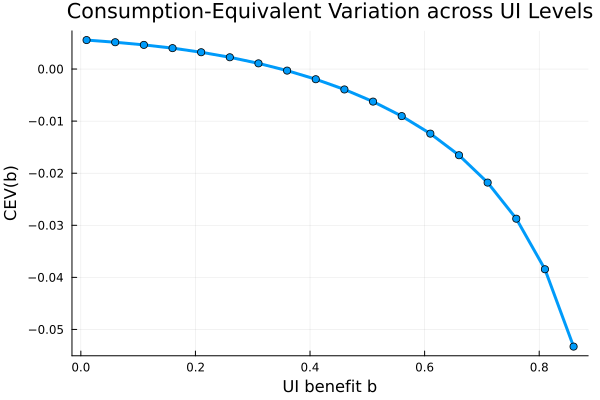

In [20]:
b      = b_simul_2[:, 1]
cev    = b_simul_2[:, 2]

plot(
    b, cev,
    xlabel = "UI benefit b",
    ylabel = "CEV(b)",
    title  = "Consumption-Equivalent Variation across UI Levels",
    legend = false,
    lw = 3,
    marker = :circle
)

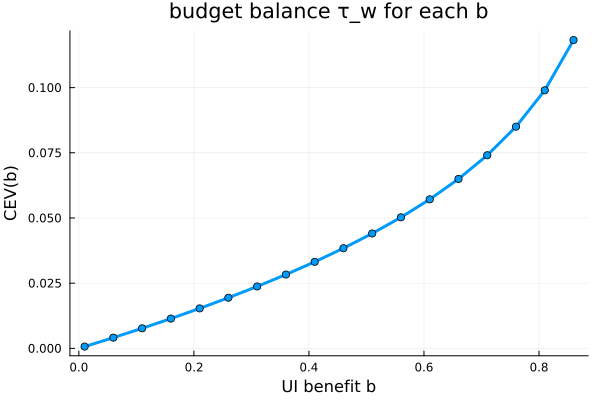

In [21]:
b      = b_simul_2[:, 1]
wage    = b_simul_2[:, 3]

plot(
    b, wage,
    xlabel = "UI benefit b",
    ylabel = "CEV(b)",
    title  = "budget balance τ_w for each b",
    legend = false,
    lw = 3,
    marker = :circle
)